In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [2]:
boids = pd.read_csv('clean_birds.csv') # read the data

boids.head() # take a peek

,Common_name,Scientific_name,Set,Color,Power_text,Flavor_text,Predator,Flocking,Bonus_card,Victory_points,...,Nest_Box_Builder,Omnivore_Expert,Passerine_Specialist,Platform_Builder,Prairie_Manager,Rodentologist,Small_Clutch_Specialist,Viticulturalist,Wetland_Scientist,Wildlife_Gardener
0,Abbott's Booby,Papasula abbotti,oceania,white,"Draw 3 bonus cards, then discard 2. You may di...","This large, endangered seabird lives only on C...",False,False,True,5,...,False,False,False,True,False,False,True,False,True,False
1,Acorn Woodpecker,Melanerpes formicivorus,core,brown,"Gain 1 [seed] from the birdfeeder, if availabl...","In a single dead tree, these birds may drill a...",False,False,False,5,...,True,False,False,False,False,False,False,False,False,False
2,American Avocet,Recurvirostra americana,core,pink,"When another player takes the ""lay eggs"" actio...","American avocets build their own nests, but th...",False,False,False,6,...,False,False,False,False,False,False,True,False,True,False
3,American Bittern,Botaurus lentiginosus,core,brown,Player(s) with the fewest birds in their [wetl...,"Bitterns hide in reeds and cattails, where the...",False,False,False,7,...,False,False,False,True,False,True,True,False,True,False
4,American Coot,Fulica americana,core,brown,Tuck 1 [card] from your hand behind this bird....,"These omnivorous birds eat a lot of algae, but...",False,True,False,3,...,False,True,False,True,False,False,False,False,True,False


In [3]:
# Drop some columns that aren't going to matter

to_drop = ['Common_name','Scientific_name', 'Flavor_text','Total_food_cost','Power_text']

boids = boids.drop(to_drop, axis=1)

boids.head()

,Set,Color,Predator,Flocking,Bonus_card,Victory_points,Nest_type,Egg_limit,Wingspan,Forest,...,Nest_Box_Builder,Omnivore_Expert,Passerine_Specialist,Platform_Builder,Prairie_Manager,Rodentologist,Small_Clutch_Specialist,Viticulturalist,Wetland_Scientist,Wildlife_Gardener
0,oceania,white,False,False,True,5,platform,1,190,False,...,False,False,False,True,False,False,True,False,True,False
1,core,brown,False,False,False,5,cavity,4,46,True,...,True,False,False,False,False,False,False,False,False,False
2,core,pink,False,False,False,6,ground,2,79,False,...,False,False,False,False,False,False,True,False,True,False
3,core,brown,False,False,False,7,platform,2,107,False,...,False,False,False,True,False,True,True,False,True,False
4,core,brown,False,True,False,3,platform,5,61,False,...,False,True,False,True,False,False,False,False,True,False


In [4]:
# Split out my target variable

pointz = boids['Victory_points']

boids = boids.drop('Victory_points', axis=1)

boids['Wingspan'] = pd.to_numeric(boids['Wingspan'], errors='coerce')

In [5]:
# Split into train and test

X_train,X_test,y_train,y_test = train_test_split(boids,pointz,test_size=.2,random_state=42)

In [6]:
num_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

cat_pipe = make_pipeline(
    SimpleImputer(strategy='constant',fill_value='None'),
    OneHotEncoder(drop='first')
)

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 17 to 102
Data columns (total 54 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Set                           356 non-null    object 
 1   Color                         350 non-null    object 
 2   Predator                      356 non-null    bool   
 3   Flocking                      356 non-null    bool   
 4   Bonus_card                    356 non-null    bool   
 5   Nest_type                     351 non-null    object 
 6   Egg_limit                     356 non-null    int64  
 7   Wingspan                      353 non-null    float64
 8   Forest                        356 non-null    bool   
 9   Grassland                     356 non-null    bool   
 10  Wetland                       356 non-null    bool   
 11  Invertebrate                  356 non-null    int64  
 12  Seed                          356 non-null    int64  
 13  Fish     

In [8]:
num_colz = ['Egg_limit','Wingspan','Invertebrate','Seed','Fish','Fruit','Rodent','Nectar','Wild_food']
cat_colz = ['Set','Color', 'Nest_type']

preprocessing = ColumnTransformer(
    transformers=[
        ('num',num_pipe,num_colz),
        ('cat',cat_pipe,cat_colz)

    ]
)

In [9]:
X_train_prepared = preprocessing.fit_transform(X_train)

In [10]:
lin_reg = LinearRegression()

lin_reg.fit(X_train_prepared,y_train)

lin_reg_rmses = -cross_val_score(lin_reg, X_train_prepared, y_train,
                                 scoring="neg_root_mean_squared_error", cv=10)

pd.Series(lin_reg_rmses).describe()


count    10.000000
mean      1.512213
std       0.181029
min       1.240433
25%       1.366152
50%       1.559037
75%       1.623771
max       1.796301
dtype: float64

In [11]:
# instantiate a RandomForestRegressor class
forest_reg = RandomForestRegressor(random_state=42)

# fit the model
forest_reg.fit(X_train_prepared, y_train)

# cross validation
forest_rmses = -cross_val_score(forest_reg, X_train_prepared, y_train,
                                scoring="neg_root_mean_squared_error", cv=10)

# check cross validation scores
pd.Series(forest_rmses).describe()

count    10.000000
mean      1.727613
std       0.223041
min       1.330360
25%       1.592041
50%       1.722068
75%       1.816701
max       2.130310
dtype: float64

In [12]:
ridge_model = Ridge(alpha=1.0)  # alpha is the regularization strength
ridge_model.fit(X_train_prepared, y_train)

ridge_rmses = -cross_val_score(ridge_model, X_train_prepared, y_train,
                                scoring="neg_root_mean_squared_error", cv=10)

pd.Series(ridge_rmses).describe()

count    10.000000
mean      1.534860
std       0.189734
min       1.292204
25%       1.358570
50%       1.570346
75%       1.670864
max       1.850779
dtype: float64

In [13]:
lasso_model = Lasso(alpha=1.0)  # alpha is the regularization strength for Lasso
lasso_model.fit(X_train_prepared, y_train)


lasso_rmses = -cross_val_score(lasso_model, X_train_prepared, y_train,
                               scoring="neg_root_mean_squared_error", cv=10)

pd.Series(lasso_rmses).describe()

count    10.000000
mean      2.043062
std       0.218143
min       1.689284
25%       1.943418
50%       2.031840
75%       2.242421
max       2.305790
dtype: float64

In [14]:
svr_model = SVR(kernel='rbf')  # Using Radial Basis Function (RBF) kernel
svr_model.fit(X_train_prepared, y_train)

svr_rmses = -cross_val_score(svr_model, X_train_prepared, y_train,
                               scoring="neg_root_mean_squared_error", cv=10)

pd.Series(svr_rmses).describe()



count    10.000000
mean      1.581839
std       0.191168
min       1.241786
25%       1.491066
50%       1.574905
75%       1.688477
max       1.918715
dtype: float64

C:\Users\nspeelman.SEIU\Anaconda3\Lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nspeelman.SEIU\Anaconda3\Lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nspeelman.SEIU\Anaconda3\Lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


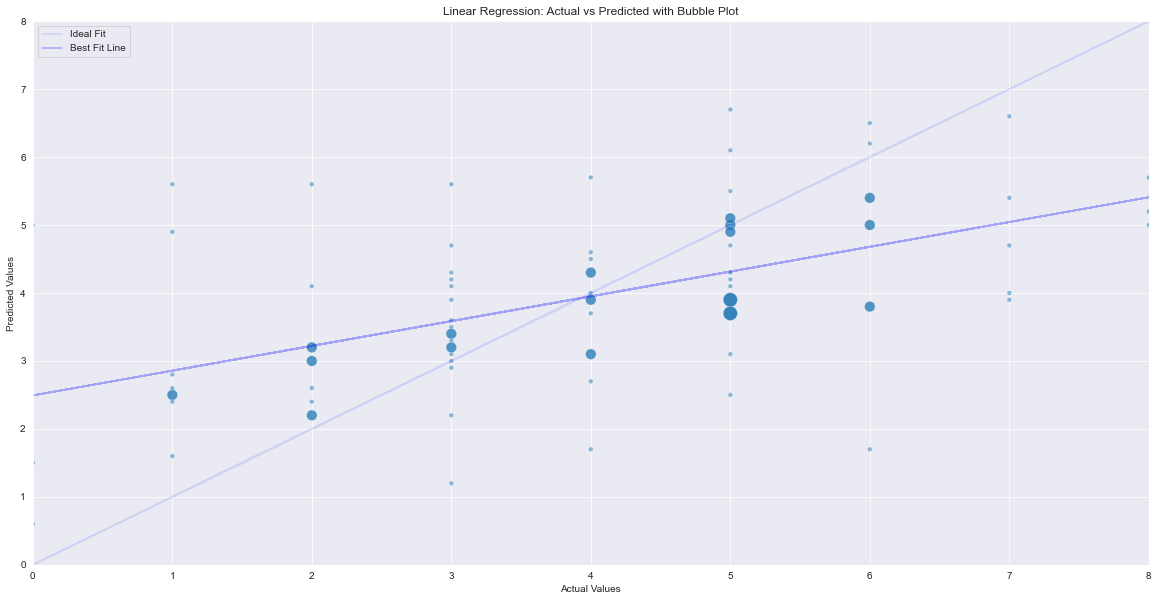

In [77]:
X_test_prepared = preprocessing.transform(X_test)
y_pred_lin = lin_reg.predict(X_test_prepared)


# Convert to DataFrame for easier manipulation
df = pd.DataFrame({
    'Actual': y_test_array,
    'Predicted': y_pred_lin_array
})

# Round the predicted values to one decimal place
df['Predicted'] = df['Predicted'].round(1)

# Count the occurrences of each (x, y) pair
counts = df.groupby(['Actual', 'Predicted']).size().reset_index(name='Counts')

# Merge the counts back to the original data
df = df.merge(counts, on=['Actual', 'Predicted'])

# Create the bubble plot
plt.figure(figsize=(20, 10))
sns.scatterplot(data=df, x='Actual', y='Predicted', size='Counts', sizes=(20, 200), legend=False, alpha=0.5)

# Plot the ideal fit line as a solid line
plt.plot(y_test_array, y_test_array, 'b-', label='Ideal Fit', alpha=0.1)

# Plot the best fit line using a faint color
m, b = np.polyfit(y_test_array, y_pred_lin_array, 1)  # Best fit line calculation
plt.plot(y_test_array, m*y_test_array + b, 'b-', label='Best Fit Line', alpha=0.3)

plt.xlim(0, 8)
plt.ylim(0, 8)

plt.title('Linear Regression: Actual vs Predicted with Bubble Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
rmse_lin

1.620336810065197

In [41]:
counts

,Actual,Predicted,Counts
0,0,0.647054,0.693147
1,0,1.503526,0.693147
2,0,4.954208,0.693147
3,1,1.591831,0.693147
4,1,2.403196,0.693147
...,...,...,...
85,7,5.422198,0.693147
86,7,6.644057,0.693147
87,8,4.958925,0.693147
88,8,5.190890,0.693147
